# wav2pos inference example

This notebook demonstrates how to run inference in a simulated room with different input masks, assuming that you have already trained the model.

First, we import the necessary libraries

In [1]:
import numpy as np
import torch
import random
from wav2pos import wav2pos
from data import DelaySimulatorDataset
import cfg
import matplotlib.pyplot as plt
%matplotlib widget

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

/home/axel/anaconda3/envs/py37/lib/python3.8/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Next, we load our pre-trained model and our pre-generated anechoic dataset

In [2]:


model = wav2pos(audio_len=cfg.sig_len, patch_size=cfg.patch_size, num_mics=cfg.num_mics,
                embed_dim=cfg.embed_dim, depth=cfg.depth, num_heads=cfg.num_heads,
                decoder_embed_dim=cfg.decoder_embed_dim, decoder_depth=cfg.decoder_depth,
                decoder_num_heads=cfg.decoder_num_heads, drop=cfg.drop, attn_drop=cfg.attn_drop,
                snr_interval=cfg.snr_interval, all_patch_loss=cfg.all_patch_loss,
                use_ngcc=cfg.use_ngcc, ngcc_path=cfg.ngcc_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)
model.load_state_dict(torch.load(
    'experiments/wav2pos_anechoic/model.pth', map_location=device))

loading ngcc pre-trained weights from experiments/ngcc_anechoic/model.pth


<All keys matched successfully>

In [3]:
delay_simulator_test = DelaySimulatorDataset(None, room_dim=cfg.room_dim_test, in_fs=cfg.in_fs,
                                    out_fs=cfg.out_fs, N=cfg.sig_len, N_gt=cfg.sig_len,
                                    t60=None,
                                    anechoic_prob=None, train=False,
                                    lower_bound=0.5, upper_bound=1.5, repeats=1,
                                    snr=None)

delay_simulator_test.load_data('experiments/ngcc_anechoic/', 'test')

loc_mu = torch.mean(delay_simulator_test.source_locs, dim=0).to(device)[0]
loc_sigma = torch.std(delay_simulator_test.source_locs, dim=0).to(device)[0]

Next, we pick a random sample from the dataset (try changing this and see what happens). The sample contains the source audio (which is a short snippet of human speech), the recordings from the 6 microphones, the source coordinate and the 6 microphone coordinates

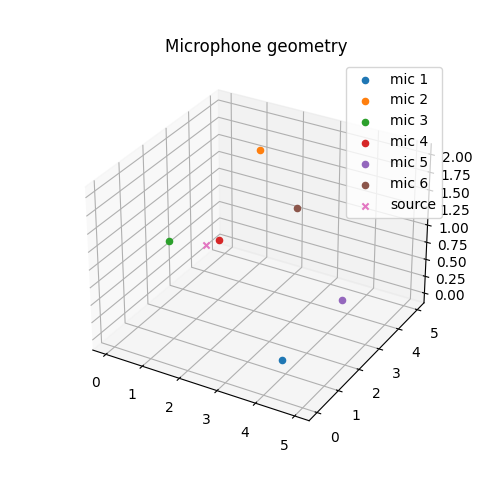

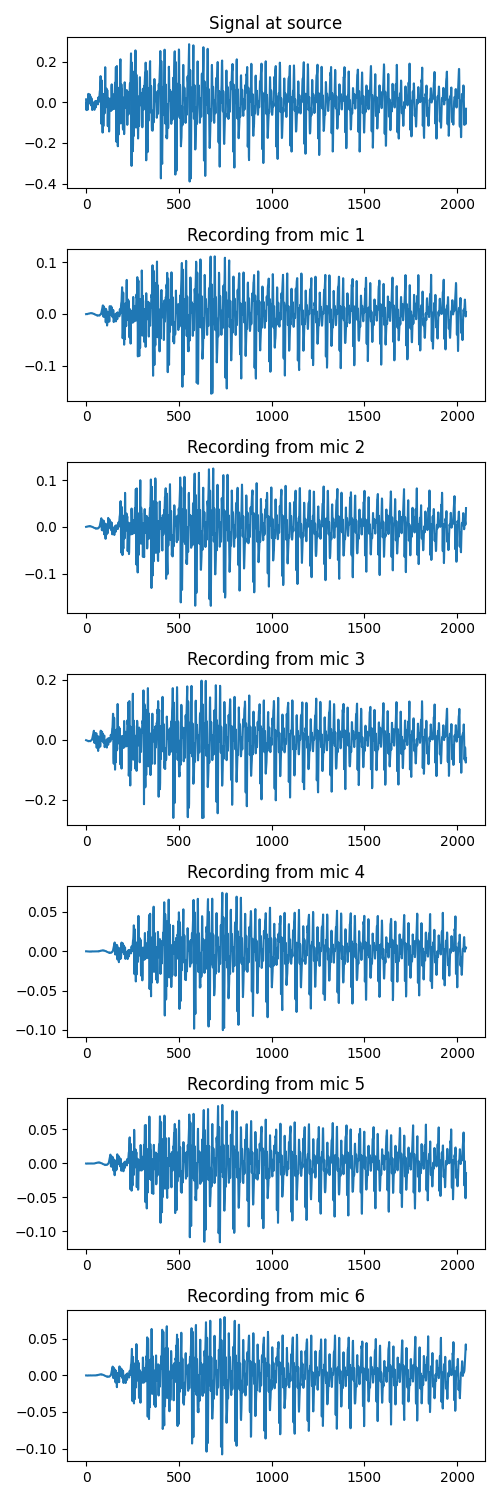

In [4]:
my_sample = 500

signals, speaker, mics, tdoas = delay_simulator_test[my_sample]
speaker = speaker.unsqueeze(0)
mics = mics.unsqueeze(0)

mic_locs = mics.permute(0, 2, 1).to(device)
bs = signals.shape[0]

start_idx = 1000 # select where to start the recording. The input should be 2048 samples long
signals = signals[:, :, start_idx:start_idx+cfg.sig_len]

plt.close()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
for i in range(6):
    ax.scatter(mic_locs[0, i, 0], mic_locs[0, i, 1], mic_locs[0, i, 2], label=f'mic {i+1}')
ax.scatter(speaker[0, 0, 0], speaker[0, 0, 1], speaker[0, 0, 2], marker='x', label='source')

plt.title('Microphone geometry')
plt.legend()

fig, axs = plt.subplots(7, figsize=(5,15))
axs[0].plot(signals[0,0])
axs[0].set_title('Signal at source')

for i in range(1, 7):
    axs[i].plot(signals[0,i])
    axs[i].set_title(f'Recording from mic {i}')

fig.tight_layout()

Next, we prepare the inputs by normalizing them.

In [5]:


# normalize signal
signals = signals.unsqueeze(1).float()

this_std = torch.std(signals, dim=-1, keepdim=True)
this_mean = torch.mean(signals, dim=-1, keepdim=True)

norm_signals = (signals - this_mean) / this_std
x = norm_signals.to(device) 

# normalized source locs
source_locs = speaker
source_locs = source_locs.to(device)
source_norm = (source_locs - loc_mu) / loc_sigma

# normalized mic locs
m_norm = (mic_locs - loc_mu) / loc_sigma

# concatenate input
locations = torch.cat((source_norm, m_norm), dim=1).float()

### Masking setup

Which inputs are seen by the model, and which ones are masked, is determined by the ids_keep variable. It is a list with the following structure:

```
[0 (source coord), 1 (mic 1 coord), ..., M (mic M coord), M+1 (source audio), M+2 (mic 1 audio), ..., 2M+1 (mic M audio)]
```

By removing elements from the list, we can determine which inputs are seen by the model, and which ones that have to be predicted. In the first example, we remove index 0 (the source coordinate) and index 7 (the source audio). This corresponds to setup $1_a$ in the paper.
```

In [6]:

ids_keep = torch.Tensor([1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]).unsqueeze(0).long()
print(ids_keep)

tensor([[ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13]])


Now we are ready to predict the source coordinate, by first running the inputs and the mask through the model, and retrieving the output at the correct index (in this case 0).

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Source estimation error = 30.476493852251462 cm


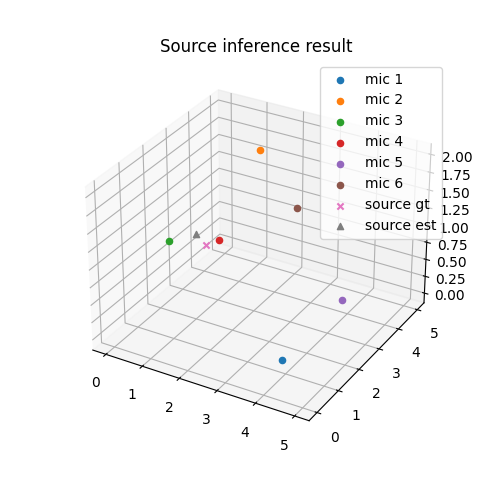

In [7]:
loss_audio, loss_locs, pred, loc_pred, mask, _, _ = model(
                                    x, locations, ids_keep, mode='test')

source_est = loc_pred[0,0].detach() * loc_sigma + loc_mu

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
for i in range(6):
    ax.scatter(mic_locs[0, i, 0], mic_locs[0, i, 1], mic_locs[0, i, 2], label=f'mic {i+1}')
ax.scatter(speaker[0, 0, 0], speaker[0, 0, 1], speaker[0, 0, 2], marker='x', label='source gt')
ax.scatter(source_est[0], source_est[1], source_est[2], marker='^', label='source est')

source_error = torch.sqrt(torch.sum((source_est-speaker.squeeze())**2))
print(f'Source estimation error = {source_error*100} cm')


plt.title('Source inference result')
plt.legend()

Now, let's try setup $1_b$, where the source audio is known. We can do this by adding the index 7 to the list.

In classical terms, this corresponds to going from a time-difference-of-arrival (TDOA) to a time-of-arrival (TOA) problem. In most cases, we expect better performance in this scenario, since it is an easier problem.

Source estimation error = 17.183466645176985 cm


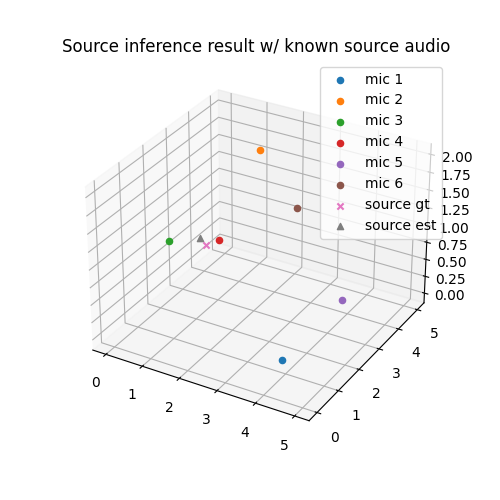

In [8]:
ids_keep = torch.Tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]).unsqueeze(0).long()

loss_audio, loss_locs, pred, loc_pred, mask, _, _ = model(
                                    x, locations, ids_keep, mode='test')

source_est = loc_pred[0,0].detach() * loc_sigma + loc_mu

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
for i in range(6):
    ax.scatter(mic_locs[0, i, 0], mic_locs[0, i, 1], mic_locs[0, i, 2], label=f'mic {i+1}')
ax.scatter(speaker[0, 0, 0], speaker[0, 0, 1], speaker[0, 0, 2], marker='x', label='source gt')
ax.scatter(source_est[0], source_est[1], source_est[2], marker='^', label='source est')

source_error = torch.sqrt(torch.sum((source_est-speaker.squeeze())**2))
print(f'Source estimation error = {source_error*100} cm')


plt.title('Source inference result w/ known source audio')
plt.legend()

Finally, we can try to remove a microphone coordinate from the inputs and see if the model can predict it. We can do this by removing index 6 from the list. This corresponds to setup $2_a$ in the paper. Microphone localization is a more difficult problem, and the errors are typically larger than for source localization.

Note that in the default setup of this repo, the model is trained by randomly masking 0 or 1 microphone, so we cannot expect it to be able to localize more than 1 microphone. However, you can chane the training setup in the `cfg.py` file and try different masking strategies, and also changing the total number of microphones.

Source estimation error = 29.811964459330543 cm
Mic estimation error = 45.95414674209816 cm
tensor([2.0371, 5.0000, 0.8460], dtype=torch.float64)
tensor([1.6198, 5.1421, 0.9757], dtype=torch.float64)


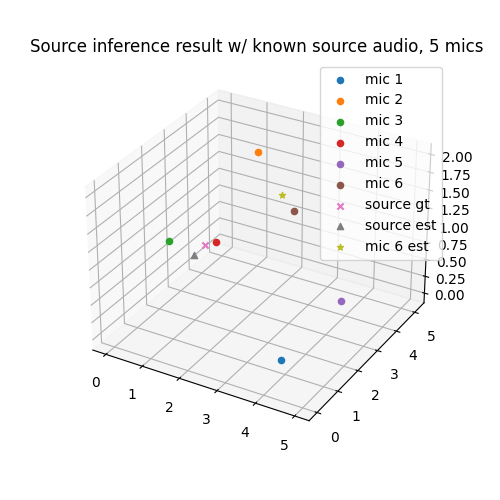

In [9]:
ids_keep = torch.Tensor([1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]).unsqueeze(0).long()

loss_audio, loss_locs, pred, loc_pred, mask, _, _ = model(
                                    x, locations, ids_keep, mode='test')

source_est = loc_pred[0,0].detach() * loc_sigma + loc_mu
mic_est = loc_pred[0, 6].detach() * loc_sigma + loc_mu

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
for i in range(6):
    ax.scatter(mic_locs[0, i, 0], mic_locs[0, i, 1], mic_locs[0, i, 2], label=f'mic {i+1}')
ax.scatter(speaker[0, 0, 0], speaker[0, 0, 1], speaker[0, 0, 2], marker='x', label='source gt')
ax.scatter(source_est[0], source_est[1], source_est[2], marker='^', label='source est')
ax.scatter(mic_est[0], mic_est[1], mic_est[2], marker='*', label='mic 6 est')

source_error = torch.sqrt(torch.sum((source_est-speaker.squeeze())**2))
mic_error = torch.sqrt(torch.sum((mic_est-mic_locs[0,5].squeeze())**2))

print(f'Source estimation error = {source_error*100} cm')
print(f'Mic estimation error = {mic_error*100} cm')

print(mic_locs[0,5])
print(mic_est)

plt.title('Source inference result w/ known source audio, 5 mics')
plt.legend()